<a href="https://colab.research.google.com/github/bahgat-ahmed/Natural-Language-Processing-in-TensorFlow/blob/main/Course_3_Week_2_Lesson_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP/Course%203%20-%20Week%202%20-%20Lesson%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# NOTE: PLEASE MAKE SURE YOU ARE RUNNING THIS IN A PYTHON3 ENVIRONMENT

import tensorflow as tf
print(tf.__version__)


2.3.0


In [4]:
# Double check TF 2.0x is installed. If you ran the above block, there was a 
# 'reset all runtimes' button at the bottom that you needed to press
import tensorflow as tf
print(tf.__version__)

2.3.0


You will look at how **tfds** has built in tokenizers that prevent you from writing a lot of the tokenizing code that we've just used.

We'll take a look at a version of the IMDb dataset that has been pre-tokenized for you, but the tokenization is done on sub words. We'll use that to demonstrate how text classification can have some unique issues, namely that the sequence of words can be just as important as their existence.

If you want to access the sub words tokenizer, you can do it with this code.

In [5]:
# If the import fails, run this
# !pip install -q tensorflow-datasets

import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteWI346H/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteWI346H/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteWI346H/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [6]:
train_data, test_data = imdb['train'], imdb['test']

In [7]:
tokenizer = info.features['text'].encoder

We have a pre-trained sub-words tokenizer now, so we can inspect its vocabulary by looking at its sub-words property. We can see there's lots of them including punctuation stuff.

In [8]:
print(tokenizer.subwords)

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_', 't_', 'with_', 'for_', '.<', 'on_', 'but_', 'movie_', ' (', 'are_', 'his_', 'have_', 'film_', 'not_', 'ing_', 'be_', 'ed_', 'you_', ' "', 'it', 'd_', 'an_', 'he_', 'by_', 'at_', 'one_', 'who_', 'y_', 'from_', 'e_', 'or_', 'all_', 'like_', 'they_', '" ', 'so_', 'just_', 'has_', ') ', 'her_', 'about_', 'out_', 'This_', 'some_', 'ly_', 'movie', 'film', 'very_', 'more_', 'It_', 'would_', 'what_', 'when_', 'which_', 'good_', 'if_', 'up_', 'only_', 'even_', 'their_', 'had_', 'really_', 'my_', 'can_', 'no_', 'were_', 'see_', 'she_', '? ', 'than_', '! ', 'there_', 'get_', 'been_', 'into_', ' - ', 'will_', 'much_', 'story_', 'because_', 'ing', 'time_', 'n_', 'we_', 'ed', 'me_', ': ', 'most_', 'other_', 'don', 'do_', 'm_', 'es_', 'how_', 'also_', 'make_', 'its_', 'could_', 'first_', 'any_', "' ", 'people_', 'great_', 've_', 'ly', 'er_', 'made_', 'r_', 'B

If we want to see how it encodes or decode strings, we can do so with this code.

In [9]:
sample_string = 'TensorFlow, from basics to mastery'

tokenized_string = tokenizer.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print ('The original string: {}'.format(original_string))


Tokenized string is [6307, 2327, 4043, 2120, 2, 48, 4249, 4429, 7, 2652, 8050]
The original string: TensorFlow, from basics to mastery


If we want to see the tokens themselves, we can take each element and decode that, showing the value to token. Note that this is case sensitive and punctuation is maintained unlike the tokenizer we saw previously.

In [10]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
2 ----> , 
48 ----> from 
4249 ----> basi
4429 ----> cs 
7 ----> to 
2652 ----> master
8050 ----> y


In [11]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_data.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset))
test_dataset = test_data.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_data))

One thing to take into account though, is the shape of the vectors coming from the tokenizer through the embedding, and it's not easily flattened. So we'll use Global Average Pooling 1D instead. Trying to flatten them, will cause a TensorFlow crash.

In [12]:
embedding_dim = 64
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 524,237
Trainable params: 524,237
Non-trainable params: 0
_________________________________________________________________


Training is dealing with a lot of hyper-parameters and sub-words, so expect it to be slow. So set it off and give it some time to train. If your results don't look good, don't worry, that's part of the point.

You see I haven't really done a whole lot of pre-processing. It's very nice that the data's already pre-processed for me. So I'm just going to pass it the training data, I'm going to pass it the number of epochs, and then I'm going to say the test data is my validation set. 


In [13]:
num_epochs = 10

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 15s 40ms/step - loss: 0.6786 - accuracy: 0.6141 - val_loss: 0.6365 - val_accuracy: 0.7607
Epoch 2/10
391/391 [==============================] - 16s 41ms/step - loss: 0.5313 - accuracy: 0.7936 - val_loss: 0.4535 - val_accuracy: 0.8322
Epoch 3/10
391/391 [==============================] - 16s 40ms/step - loss: 0.3756 - accuracy: 0.8683 - val_loss: 0.3748 - val_accuracy: 0.8464
Epoch 4/10
391/391 [==============================] - 15s 40ms/step - loss: 0.3026 - accuracy: 0.8907 - val_loss: 0.3341 - val_accuracy: 0.8668
Epoch 5/10
391/391 [==============================] - 16s 40ms/step - loss: 0.2644 - accuracy: 0.9042 - val_loss: 0.3169 - val_accuracy: 0.8780
Epoch 6/10
391/391 [==============================] - 16s 40ms/step - loss: 0.2356 - accuracy: 0.9159 - val_loss: 0.3074 - val_accuracy: 0.8800
Epoch 7/10
391/391 [==============================] - 15s 39ms/step - loss: 0.2165 - accuracy: 0.9217 - val_loss: 0.3132 - val_accuracy:

You can graph the results with this code. The key is in the fact that we're using sub-words and not fullwords, sub-word meanings are often nonsensical and it's only when we put them together in sequences that they have meaningful semantics. Thus, some way from learning from sequences would be a great way forward, and that's exactly what you're going to do next week with recurrent neural networks.

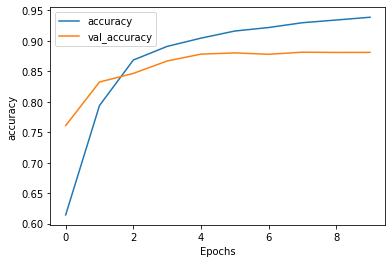

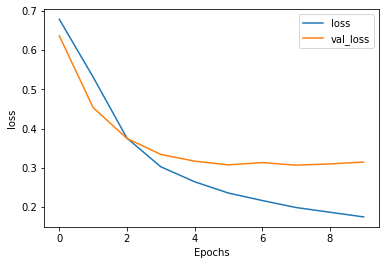

In [14]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [15]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, tokenizer.vocab_size):
  word = tokenizer.decode([word_num])
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()


try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

(8185, 64)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>